In [1]:
import delfi.distribution as dd
import delfi.generator as dg
import delfi.inference as infer
import delfi.summarystats as ds

from delfi.simulator.BaseSimulator import BaseSimulator

import matplotlib.pyplot as plt
import numpy as np

from delfi.utils.viz import plot_pdf

from tqdm import tqdm_notebook as tqdm

%matplotlib inline

WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [2]:
seed = 678

model_noise = 0.0
alpha = 1             # Slope
prior_var = 20

true_params = np.array([3])

In [34]:
def plot_pdfs(dists, lims=None):
    if lims == None:
        lims = [ -3 * np.sqrt(prior_var), 3 * np.sqrt(prior_var) ]
    xlist = np.linspace(lims[0], lims[1], 400)
    
    fig, ax = plt.subplots(1, figsize=(12, 3))
    
    ndists = len(dists)
    for i in range(ndists):
        d = dists[i]
        ylist = d.eval(xlist.reshape((-1,1)), log=False)# [ d.eval([x], log=False) for x in xlist ]
        ax.plot(xlist, ylist, label="Round {}".format(i), c=[0,1 - i / ndists,0])
        
    ax.axvline(true_params, c='k', ls='--')
    
    box = ax.get_position()
    ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
        
    plt.show()
    
    return fig

## Can SNPE accurately predict multimodal distributions?

Short answer: No. Even in the simple model above, where the problem is to fit a bimodal posterior, SNPE initialised with two components only yields a bimodal posterior in some cases (depending on the seed).

One possible explanation: [Ian Goodfellow, NIPS 2016 Tutorial: GANs, Fig. 14] SNPE tries to assign high posterior probabilities to likely regions (maximum likelihood model), and it does not try to assign low posterior probabilities to unlikely regions. However, Goodfellow states in Sec. 5 that this is not likely the master explanation.

Other theory: Gradient descent is done in batches. If batch sizes are too small and not all batches contain enough elements from all modes, this could result in mode dropping

In [4]:
def get_dkl(p, q, n_samples=40000):
    samples = p.gen(n_samples)
    return -np.mean(q.eval(samples, log=True) - p.eval(samples, log=True))

def plot_family(dists, xes, target=None, labels=None, title=None, once_every = 1):
    xlist = 2 * np.linspace(-true_params, true_params, 100)
    
    fig, (axpdf, axdkl) = plt.subplots(2, figsize=(8, 6))
    
    if title is not None:
        fig.suptitle(title)
        
    ndists = len(dists)
    if labels is None:
        labels = [ None for i in range(ndists) ]
        
    for i in range(0, ndists, once_every):
        d = dists[i]
        ylist = d.eval(xlist.reshape((-1,1)), log=False)
        axpdf.plot(xlist, ylist, label=labels[i], c=[0,1 - i / ndists,0])
    
    if target is not None:
        ylist = target.eval(xlist.reshape((-1,1)), log=False)
        axpdf.plot(xlist, ylist, label="Target", c='r')
        
    box = axpdf.get_position()
    axpdf.set_position([box.x0, box.y0, box.width * 0.8, box.height])
    axpdf.legend(loc='center left', bbox_to_anchor=(1, 0.5))

    if target is None:
        target = dists[-1]
        
    dkls = [ get_dkl(target, i) for i in dists ]
    axdkl.plot(xes, dkls, label='$KL(p || q_i)$')

    dklrs = [ get_dkl(i, target) for i in dists ]
    axdkl.plot(xes, dklrs, label='$KL(q_i || p)$')
    
    axdkl.set_xlabel('l')
    axdkl.set_ylabel('$KL$')
    
    box = axdkl.get_position()
    axdkl.set_position([box.x0, box.y0, box.width * 0.8, box.height])
    axdkl.legend(loc='center left', bbox_to_anchor=(1, 0.5))

    plt.show()

<IPython.core.display.Javascript object>


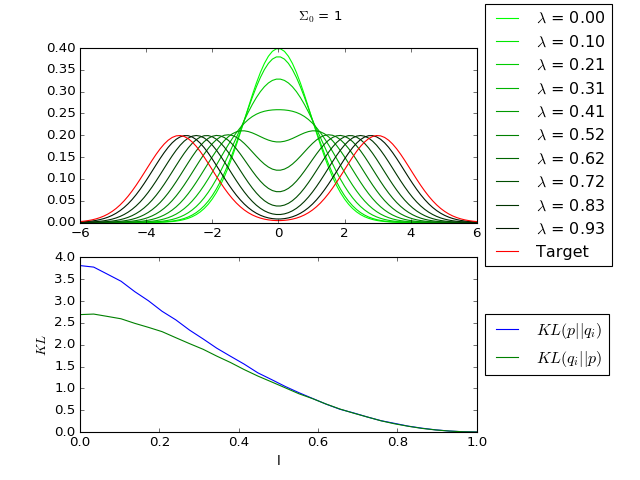

<IPython.core.display.Javascript object>


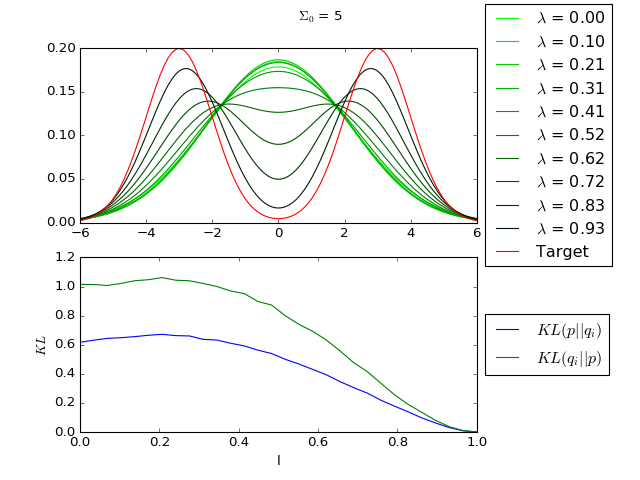

<IPython.core.display.Javascript object>


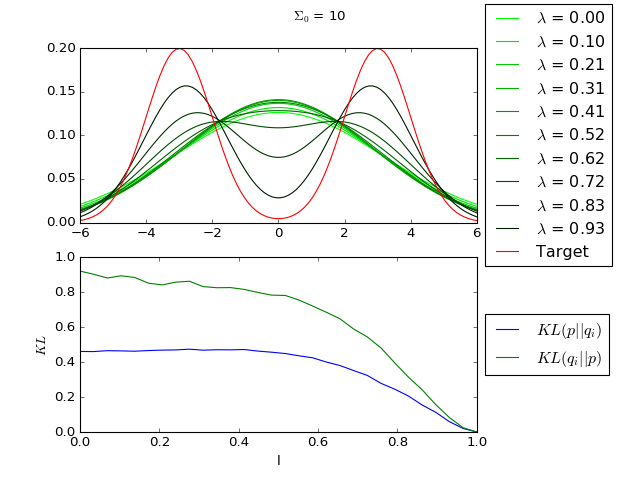

In [6]:
S_bimod =np.eye(1)
    
# Interpolate between unimodal and bimodal posteriors
def interp_lin(S_unimod, ls):
    return [ dd.MoG(a=[0.5, 0.5], ms=[-true_params * l, true_params * l], 
                    Ss=np.abs([S_bimod * l + (1 - l) * S_unimod] * 2)) for l in ls ]

ls = np.linspace(0, 1, 30)

target = interp_lin(1, [1])[0]

for s in [ 1, 5, 10 ]:
    plot_family(interp_lin(S_unimod=s, ls=ls), xes=ls, target=target, title="$\Sigma_0$ = {}".format(s), 
                labels= [ "$\lambda$ = {:03.2f}".format(l) for l in ls ], once_every = 3)

In [66]:
import torch as to

dtype = to.FloatTensor
n_samples = 2000

vm = to.autograd.Variable((to.rand(2) - 1)* 2, requires_grad=True)

vvar = to.autograd.Variable(to.rand(2), requires_grad=True)

lr = 0.5 / n_samples

def myeval(vm, vvar, sample):
    p1 = 1 / (vvar[0] * 0.5).exp() * (0.5 * (vm[0] - sample[0]) / vvar[0].exp()).exp()
    p2 = 1 / (vvar[1] * 0.5).exp() * (0.5 * (vm[1] - sample[0]) / vvar[1].exp()).exp()
    
    prob = 0.5 * (p1 + p2) / np.sqrt(2 * np.pi)
    
    tprob = target.eval([sample], log=False)
    
    return prob.log() - np.log(tprob)[0]

vms = []
vvars = []

for r in range(20):
    samples = target.gen(n_samples)
    
    loss = to.autograd.Variable(to.zeros(1), requires_grad=True)
    losses = [ myeval(vm, vvar, sample) for sample in samples ]
    
    for x in losses:
        loss = loss + x
    
    loss.backward()
    
    vm.data -= lr * vm.grad.data
    vvar.data -= lr * vvar.grad.data
    
    vm.grad.data.zero_()
    vvar.grad.data.zero_()
        
    vms.append(vm.data.numpy().copy())
    vvars.append(vvar.data.numpy().copy())

<IPython.core.display.Javascript object>


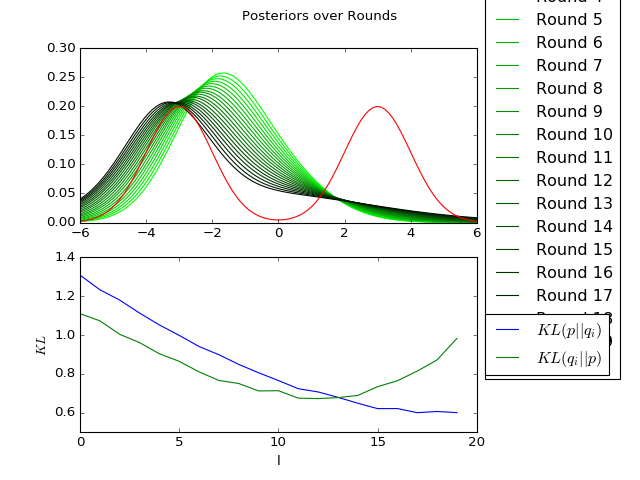

In [67]:
rets = [ dd.MoG(a=[0.5, 0.5], ms=[[vm[0]],[vm[1]]], 
                    Ss=[[[np.exp(vvar[0])]],[[np.exp(vvar[1])]]]) for vm, vvar in zip(vms, vvars) ]

plot_family(rets, xes = range(len(rets)), target=target, title="Posteriors over Rounds", 
            labels= [ "Round {}".format(i) for i in range(len(rets)) ])

## Analysis of the DKL term in moving from a unimodal to a bimodal distribution

As one can see, if the variance of the unimodal distribution is in a certain regime favoured by maximum-likelihood fitting, a significant change in the parameters is required for the target DKL to start dropping